# Examples of using the WorkloadFit class

 - Read/generate data from:
 
### 1. Log data for neuroscience applications
### 2. Synthetic data (truncnormal, exponential)

 - Plot figures with data and best fits
 - Print costs for discrete/optimal/clarvoyant/interpolation sequences

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st

import WorkloadFit

# 1. Log data

`cost_model = WorkloadFit.LogDataCost(data)`

- first 1000 sampes as training
- using both interpolation models (polynomial and distribution)

In [2]:
dataset = "fMRIQA"
data = pd.Series(np.loadtxt("ACCRE/"+dataset+".out", delimiter=' '))

training = data[:1000]
cost_model = WorkloadFit.LogDataCost(data)
print("Total entries in the datalog: %d" %(len(data)))

Total entries in the datalog: 7204


In [3]:
wf = WorkloadFit.WorkloadFit(data, cost_model, bins=100)
cost = wf.compute_discrete_cost()
print("Optimal cost: %5.2f" %(cost))

Optimal cost: 532.69


In [4]:
wf.set_workload(training)
cost = wf.compute_discrete_cost()
print("Discrete cost: %5.2f" %(cost))

Discrete cost: 558.74


In [5]:
wf.set_interpolation_model(WorkloadFit.PolyInterpolation(max_order=20))
cost = wf.compute_interpolation_cost()
poly_params = wf.get_best_fit()
print("Polynomial fit cost: %5.2f" %(cost))

Polynomial fit cost: 10011.88


In [6]:
wf.set_interpolation_model(WorkloadFit.DistInterpolation())
cost = wf.compute_interpolation_cost()
dist_params = wf.get_best_fit()
print("Distribution fit cost: %5.2f" %(cost))
print(dist_params)

Distribution fit cost: 630.69
(<scipy.stats._continuous_distns.laplace_gen object at 0x7f24c5ba6438>, (274.99999996013736, 35.77697528559838), 0.00029369209137564513)


### Plot data and the best polynomial and distribution fits

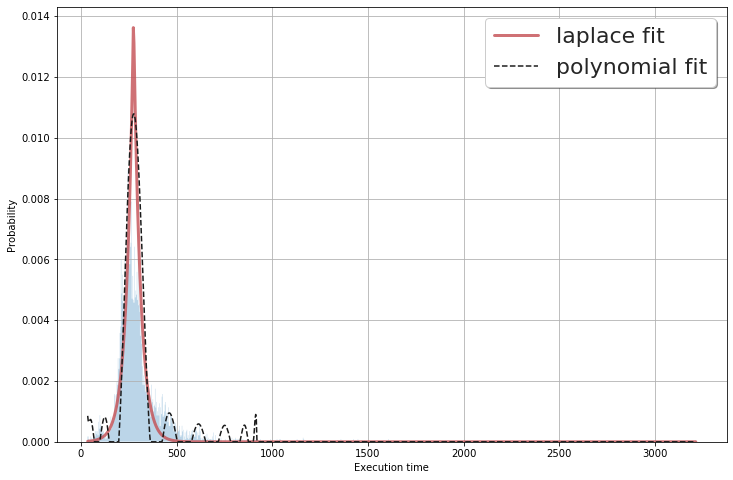

In [7]:
y, x = np.histogram(data, bins=1000, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax.plot(x, dist_params[0].pdf(x, loc=dist_params[1][-2], scale=dist_params[1][-1], *dist_params[1][:-2]),
        'r-', lw=3, alpha=0.8, label='%s fit' %(dist_params[0].name))
ax.plot(x, [max(0,np.polyval(poly_params[1], i)) for i in x], 'k--' ,label='polynomial fit')
ax.hist(data, bins=1000, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
#ax.set_ylim([0, 0.006])
plt.grid(True)
ax.set_xlabel('Execution time')
ax.set_ylabel('Probability')
plt.show()

# 2. Synthetic data
### Using truncnormal 
between 0 and 20 with `mean=8`, `sigma=2`

`cost_model = WorkloadFit.SyntheticDataCost(data, [0, 20])`

In [8]:
number_samples = 500

upper_limit = 20
lower_limit = 0

upper_bound = (upper_limit - 8) / 2
lower_bound = (lower_limit - 8) / 2

mu = 8
sigma = 2

data = st.truncnorm.rvs(lower_bound, upper_bound, loc=8, scale=2, size=number_samples)
cdf_function = lambda val: st.truncnorm.cdf(val, lower_bound, upper_bound, loc=8, scale=2)
cost_model = WorkloadFit.SyntheticDataCost(cdf_function, [0, 20])
print("Bounds: (%3.1f %3.1f) mean=%3.1f; sigma=%3.1f" %(min(data), max(data), np.mean(data), np.std(data)))

Bounds: (1.9 14.3) mean=8.0; sigma=2.1


In [11]:
wf = WorkloadFit.WorkloadFit(data, cost_model)

wf.set_interpolation_model(WorkloadFit.DistInterpolation())
wf.set_best_fit([st.truncnorm, (lower_bound, upper_bound, 8, 2)])
cost = wf.compute_interpolation_cost()
print("Optimal cost: %5.2f" %(cost))

Optimal cost: 11.94


In [12]:
cost = wf.compute_discrete_cost()
print("Discrete cost: %5.2f" %(cost))

Discrete cost: 11.96


### Fitting the data:
* using a list of distributions
* using polynomials up to 20th order

In [13]:
wf.set_interpolation_model(WorkloadFit.DistInterpolation())
cost = wf.compute_interpolation_cost()
dist_params = wf.get_best_fit()
print("Distribution fit cost: %5.2f" %(cost))

Distribution fit cost: 11.95


In [14]:
wf.set_interpolation_model(WorkloadFit.DistInterpolation(list_of_distr=[st.norm]))
cost = wf.compute_interpolation_cost()
norm_params = wf.get_best_fit()
print("Semi-clarvoyant fit cost: %5.2f" %(cost))

Semi-clarvoyant fit cost: 11.94


In [15]:
wf.set_interpolation_model(WorkloadFit.PolyInterpolation(max_order=20))
cost = wf.compute_interpolation_cost()
poly_params = wf.get_best_fit()
print("Polynomial fit cost: %5.2f" %(cost))

Polynomial fit cost: 19.96


### Plot data and the best polynomial and distribution fits

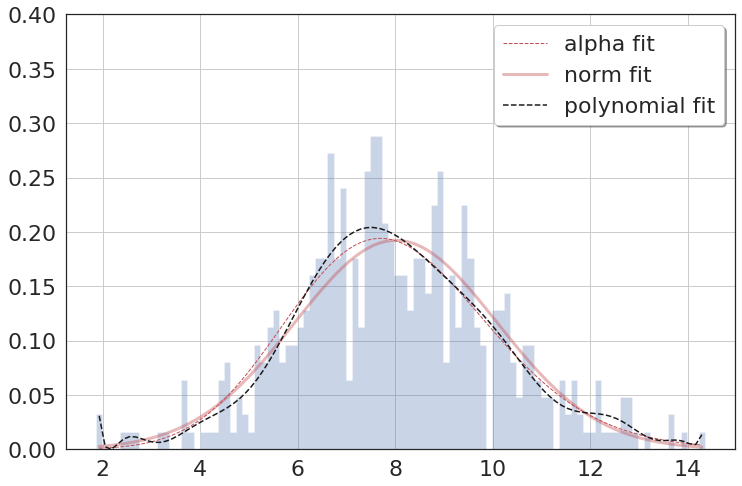

In [16]:
y, x = np.histogram(data, bins=100, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")

# plot the best fit line
best_distribution = dist_params[0]
best_params = dist_params[1]
ax.plot(x, best_distribution.pdf(x, loc=best_params[-2], scale=best_params[-1], *best_params[:-2]),
        'r--', lw=1, alpha=1.0, label='%s fit' %(best_distribution.name))
# plot the normal line
ax.plot(x, st.norm.pdf(x, *norm_params[1]),
        'r-', lw=3, alpha=0.4, label='norm fit')
# plot the polynomial fit
ax.plot(x, [max(0,np.polyval(poly_params[1], i)) for i in x], 'k--' ,label='polynomial fit')
ax.hist(data, bins=100, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
ax.set_ylim(0,0.4)
plt.grid(True)

plt.show()